# Rice Disease Detection - Smart Pipeline

**Smart Features:**
- Checks for existing trained models first
- Skips training if model exists
- Goes directly to disease analysis

**Detects 5 categories:** Bacterial Leaf Blight, Healthy Leaf, Rice, Rice Blast, Tungro

In [ ]:
# Setup and Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import json

%matplotlib inline
print('✅ Setup complete!')
print(f'TensorFlow version: {tf.__version__}')

: 

In [ ]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001

DATASET_PATH = 'dataset/Rice Leaf and Crop Disease Detection Dataset'
MODEL_PATH = 'models/rice_disease_cnn_model.h5'
CONFIG_PATH = 'models/rice_disease_cnn_model_config.json'

CLASS_NAMES = ['Bacterial Leaf Blight', 'Healthy _leaf', 'Rice', 'Rice Blast', 'Tungro']

print(f'Dataset: {DATASET_PATH}')
print(f'Classes: {CLASS_NAMES}')
print(f'Image size: {IMG_SIZE}')

: 

In [3]:
# Smart Model Loading - Check for Existing Model
if os.path.exists(MODEL_PATH) and os.path.exists(CONFIG_PATH):
    print('🎯 FOUND EXISTING TRAINED MODEL!')
    print('=' * 40)
    print('✅ Loading existing model...')
    
    model = keras.models.load_model(MODEL_PATH)
    
    with open(CONFIG_PATH, 'r') as f:
        model_config = json.load(f)
    
    print('✅ Model loaded successfully!')
    
    # Safe formatting for accuracy
    accuracy = model_config.get('final_accuracy', 'N/A')
    if isinstance(accuracy, (int, float)):
        print(f'📊 Previous accuracy: {accuracy:.4f}')
    else:
        print(f'📊 Previous accuracy: {accuracy}')
    
    print(f'🔄 Epochs trained: {model_config.get("epochs_trained", "N/A")}')
    print('⏰ Skipping training - going to disease analysis!')
    
    SKIP_TRAINING = True
    
else:
    print('❌ NO EXISTING MODEL FOUND')
    print('🔧 Will create and train new model...')
    
    def create_cnn_model(input_shape=(224, 224, 3), num_classes=5):
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        return model
    
    model = create_cnn_model(input_shape=(*IMG_SIZE, 3), num_classes=len(CLASS_NAMES))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print('✅ New model created and compiled.')
    model.summary()
    
    SKIP_TRAINING = False

❌ NO EXISTING MODEL FOUND
🔧 Will create and train new model...


✅ New model created and compiled.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                       

In [4]:
# Data Loading (Only if training needed)
if not SKIP_TRAINING:
    print('📁 Setting up data generators...')
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    print('✅ Data generators created!')
else:
    print('⏭️ SKIPPING data preparation - using existing model')

📁 Setting up data generators...
Found 8615 images belonging to 5 classes.
Found 2151 images belonging to 5 classes.
✅ Data generators created!


In [5]:
# Training (Only if needed)
if not SKIP_TRAINING:
    print(f'🚀 Starting training for {EPOCHS} epochs...')
    
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    ]

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print('✅ Training completed!')
    
    # Save model
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f'📊 Final accuracy: {val_accuracy:.4f}')
    
    os.makedirs('models', exist_ok=True)
    model.save(MODEL_PATH)
    print(f'💾 Model saved to: {MODEL_PATH}')

    model_config = {
        'model_name': 'rice_disease_cnn_model',
        'input_shape': list(IMG_SIZE) + [3],
        'num_classes': len(CLASS_NAMES),
        'class_names': CLASS_NAMES,
        'batch_size': BATCH_SIZE,
        'epochs_trained': len(history.history['loss']),
        'final_accuracy': float(val_accuracy),
        'final_loss': float(val_loss)
    }

    with open(CONFIG_PATH, 'w') as f:
        json.dump(model_config, f, indent=2)

    print(f'📋 Config saved to: {CONFIG_PATH}')
    
else:
    print('⏭️ SKIPPING TRAINING - Using existing model')
    print('💡 To retrain: delete model files and run again')

🚀 Starting training for 30 epochs...
Epoch 1/30


270/270 [==============================] - 462s 2s/step - loss: 1.2441 - accuracy: 0.4699 - val_loss: 0.9312 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 2/30
270/270 [==============================] - 207s 766ms/step - loss: 0.7888 - accuracy: 0.6966 - val_loss: 0.7921 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 3/30
270/270 [==============================] - 252s 933ms/step - loss: 0.6880 - accuracy: 0.7403 - val_loss: 0.6453 - val_accuracy: 0.7517 - lr: 0.0010
Epoch 4/30
270/270 [==============================] - 236s 872ms/step - loss: 0.6379 - accuracy: 0.7553 - val_loss: 0.6174 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 5/30
270/270 [==============================] - 203s 752ms/step - loss: 0.6012 - accuracy: 0.7702 - val_loss: 0.5661 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 6/30
270/270 [==============================] - 315s 1s/step - loss: 0.5911 - accuracy: 0.7721 - val_loss: 0.6317 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 7/30
27

C:\Users\fahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


💾 Model saved to: models/rice_disease_cnn_model.h5
📋 Config saved to: models/rice_disease_cnn_model_config.json


In [6]:
# Disease Analysis Functions
def predict_disease(image_path, model, class_names, img_size=(224, 224)):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        predictions = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        
        all_probabilities = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
        
        return {
            'predicted_class': class_names[predicted_class_idx],
            'confidence': float(confidence),
            'all_probabilities': all_probabilities
        }
    except Exception as e:
        print(f'Error predicting image: {e}')
        return None

def analyze_rice_disease(image_path):
    print(f'🔍 ANALYZING: {os.path.basename(image_path)}')
    print('=' * 40)
    
    if not os.path.exists(image_path):
        print(f'❌ Image not found: {image_path}')
        return None
        
    result = predict_disease(image_path, model, CLASS_NAMES, IMG_SIZE)
    
    if result:
        print(f'🎯 DIAGNOSIS: {result["predicted_class"]}')
        print(f'📊 CONFIDENCE: {result["confidence"]:.4f} ({result["confidence"]*100:.1f}%)')
        
        if result['confidence'] > 0.8:
            print('✅ HIGH CONFIDENCE - Reliable diagnosis')
        elif result['confidence'] > 0.6:
            print('⚠️ MEDIUM CONFIDENCE - Consider additional analysis')
        else:
            print('❌ LOW CONFIDENCE - Image may be unclear')
        
        print('\n📊 TOP 3 PREDICTIONS:')
        sorted_probs = sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True)
        for i, (class_name, prob) in enumerate(sorted_probs[:3]):
            emoji = '🥇' if i == 0 else '🥈' if i == 1 else '🥉'
            print(f'   {emoji} {class_name}: {prob:.4f} ({prob*100:.1f}%)')
        
        img = Image.open(image_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(f'RICE DISEASE DIAGNOSIS\n{result["predicted_class"]} (Confidence: {result["confidence"]*100:.1f}%)', 
                 fontsize=18, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print('\n✅ Analysis complete!')
    
    return result

print('🚀 ANALYSIS FUNCTIONS READY!')

🚀 ANALYSIS FUNCTIONS READY!


🔍 RICE DISEASE ANALYSIS

📸 Testing: healthy_leaf_sample.jpg
🔍 ANALYZING: healthy_leaf_sample.jpg
🎯 DIAGNOSIS: Healthy _leaf
📊 CONFIDENCE: 1.0000 (100.0%)
✅ HIGH CONFIDENCE - Reliable diagnosis

📊 TOP 3 PREDICTIONS:
   🥇 Healthy _leaf: 1.0000 (100.0%)
   🥈 Tungro: 0.0000 (0.0%)
   🥉 Rice Blast: 0.0000 (0.0%)


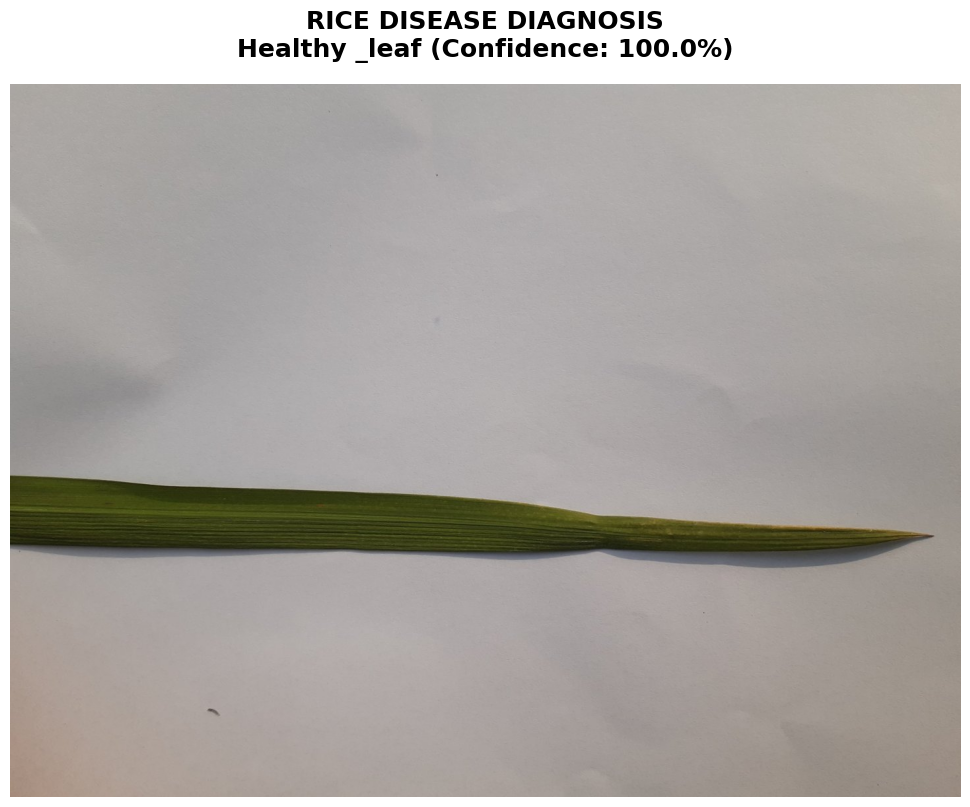


✅ Analysis complete!

📸 Testing: rice_blast_sample.jpg
🔍 ANALYZING: rice_blast_sample.jpg
🎯 DIAGNOSIS: Rice Blast
📊 CONFIDENCE: 0.9954 (99.5%)
✅ HIGH CONFIDENCE - Reliable diagnosis

📊 TOP 3 PREDICTIONS:
   🥇 Rice Blast: 0.9954 (99.5%)
   🥈 Bacterial Leaf Blight: 0.0028 (0.3%)
   🥉 Healthy _leaf: 0.0018 (0.2%)


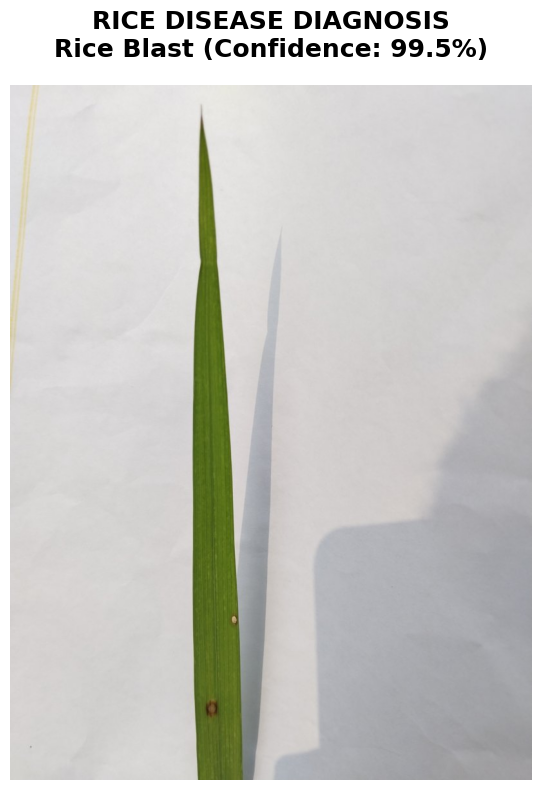


✅ Analysis complete!

✅ TESTING COMPLETE!


In [7]:
# Test with Sample Images
print('🔍 RICE DISEASE ANALYSIS')
print('=' * 50)

sample_images = [
    'sample_images/healthy_leaf_sample.jpg',
    'sample_images/rice_blast_sample.jpg'
]

for image_path in sample_images:
    if os.path.exists(image_path):
        print(f'\n📸 Testing: {os.path.basename(image_path)}')
        result = analyze_rice_disease(image_path)
    else:
        print(f'❌ Sample not found: {image_path}')
        print('   Make sure sample images are in sample_images folder')

print('\n✅ TESTING COMPLETE!')

In [8]:
# System Summary
print('🎉 RICE DISEASE DETECTION SYSTEM READY!')
print('=' * 50)

if SKIP_TRAINING:
    print('✅ SMART LOADING: Used existing trained model')
    if os.path.exists(CONFIG_PATH):
        with open(CONFIG_PATH, 'r') as f:
            config = json.load(f)
        
        # Safe formatting for accuracy
        accuracy = config.get('final_accuracy', 'N/A')
        if isinstance(accuracy, (int, float)):
            print(f'   📊 Model accuracy: {accuracy:.4f}')
        else:
            print(f'   📊 Model accuracy: {accuracy}')
        
        print(f'   🔄 Epochs trained: {config.get("epochs_trained", "N/A")}')
        print('   ⚡ Time saved: No training needed!')
else:
    print('✅ NEW MODEL: Successfully trained new model')

print('\n📋 SYSTEM CAPABILITIES:')
print(f'   🔍 Detects {len(CLASS_NAMES)} rice disease categories')
print(f'   📐 Input image size: {IMG_SIZE}')
print(f'   🏷️ Classes: {", ".join(CLASS_NAMES)}')

print('\n🔧 MAIN FUNCTIONS:')
print('   🎯 analyze_rice_disease(image_path) - Main analysis function')
print('   📊 predict_disease(...) - Detailed prediction function')

print('\n🎯 READY FOR DISEASE ANALYSIS!')
print('   Use: analyze_rice_disease("your_image.jpg")')
print('\n💡 Example: analyze_rice_disease("sample_images/healthy_leaf_sample.jpg")')

🎉 RICE DISEASE DETECTION SYSTEM READY!
✅ NEW MODEL: Successfully trained new model

📋 SYSTEM CAPABILITIES:
   🔍 Detects 5 rice disease categories
   📐 Input image size: (224, 224)
   🏷️ Classes: Bacterial Leaf Blight, Healthy _leaf, Rice, Rice Blast, Tungro

🔧 MAIN FUNCTIONS:
   🎯 analyze_rice_disease(image_path) - Main analysis function
   📊 predict_disease(...) - Detailed prediction function

🎯 READY FOR DISEASE ANALYSIS!
   Use: analyze_rice_disease("your_image.jpg")

💡 Example: analyze_rice_disease("sample_images/healthy_leaf_sample.jpg")
